# XGBoost-based typhoon predictor for the Philippines

# I. Introduction

The Philippines is an archipelago that is exposed to the Pacific typhoon belt.
Typhoons have brought severe socioeconomic impacts such as damages to infrastructure, agriculture, and communities. These impacts are magnified in far-flung, at-risk areas because of limited access to resources and information.


Machine learning methods have seen potential in improving typhoon preparedness and response. Accurate predictions can enable timely evacuations, resource allocation, and disaster relief efforts.

The objective of this notebook is to develop and evaluate a time series regression model for typhoon prediction; specifically, I aim to predict the final 5 months of typhoon counts. To achieve this, I explored and compared various evaluation methodologies, each with varying degrees of complexity.


# II. Dataset

The typhoon data is avaiable in Kaggle [[1]](https://www.kaggle.com/datasets/chriszhengao/rsmc-tokyo-typhoon-center-best-track-data/data) and is derived from the Regional Specialized Meteorological Center (RSMC) of Japan Meteorological Agency (JMA) [[2]](https://www.jma.go.jp/jma/jma-eng/jma-center/rsmc-hp-pub-eg/Besttracks/e_format_bst.html). 

The following features were used:
1. Center position of tropical cyclone (longitude, latitude) <br>
2. Central pressure (hPa) <br>
3. Maximum sustained wind speed (knots) <br>
4. Typhoon grade <br>
5. Date/time of analysis (yyyy-mm-dd) <br>


Aside from the typhoon data, **Oceanic Nino Index (ONI)** and **Dipole Mode Index (DMI)** are sourced from NOAA. ONI quantifies the strength of El Niño or La Niña events, while DMI measures the strength of the Indian Ocean Dipole (IOD); the latter is an irregular oscillation of sea surface temperatures (SST) between the western and eastern Indian Ocean.

The dataset was preprocessed prior to analysis to yield additional features like the typhoon count; comprehensive details are provided in a separate repository.

The consolidated dataset $D$ comprised monthly records from March 1951 to May 2023 (originally Feb 19 1951 to Jun 17 2023, but I need a complete monthly set) and  included the following predictors: the number of typhoons (NUM_TYPHOONS), ONI (a widely used climate indicator associated with ENSO variability), and DMI. 

# III. Holdout method for weather data

I initially considered a simple holdout method, where the data is split into a single training and test set; This method was applied to the consolidated dataset $D$. I engineered lag-based features from both predictors by extracting values from 1 to 12 months prior for each time step. This sliding window of historical context (t–1 to t–12) was then used to predict the count at time t; this enabled the model to learn temporal dependencies without peeking into the future. To align with this design, the first 12 months were reserved for feature construction, reducing the effective training sample size accordingly.

The simple holdout strategy was commenced by reserving the final 5 data points as the test set. The remaining portion of the dataset was used for training, ensuring that no future information contaminated the model during learning. We employed XGBoost, a tree-based gradient boosting algorithm known for its robustness and interpretability in small-to-medium sized tabular datasets. Performance was evaluated using three metrics: mean absolute error (MAE), root mean squared error (RMSE), and $R^{2}$; these provide a balanced view of both average error magnitude and overall explanatory power.

MAE:  0.90
RMSE: 0.94
R²:   0.77

Predictions for the last 5 months:
        DATE  Actual  Predicted
0 2020-10-01       5        4.0
1 2020-11-01       4        3.0
2 2020-12-01       1        2.0
3 2021-01-01       0        1.0
4 2021-02-01       1        0.0


<Figure size 640x480 with 0 Axes>

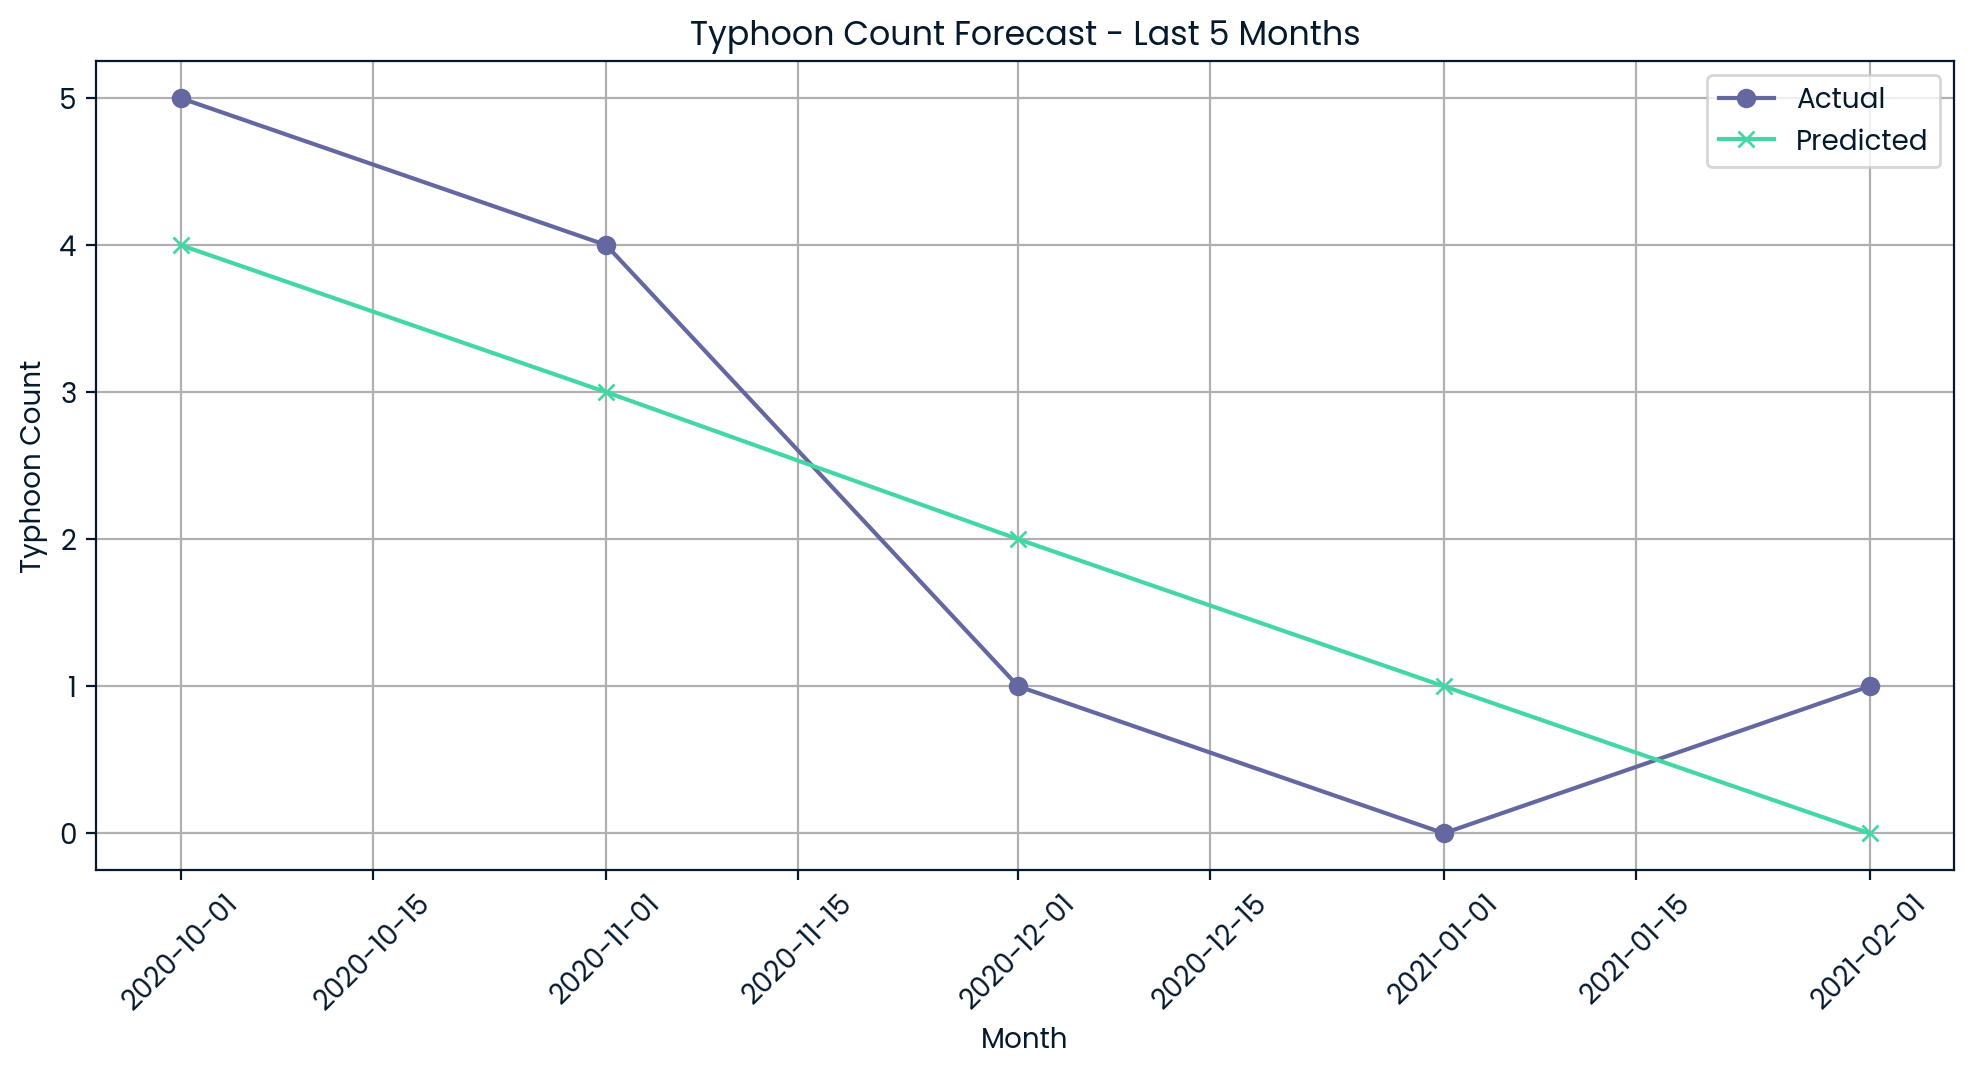

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the dataset
filename = 'DATA/preprocessed_typhoon_data_par_with_iode_and_oni.csv'
df = pd.read_csv(filename)
df['DATE'] = pd.to_datetime(df['yearmonth'].astype(str) + '01', format='%Y%m%d')

# Feature Selection and Lag Feature Creation
# Define the columns to use
selected_columns = [
    'duration_par',
    'average_wind_speed',
    'max_wind_speed',
    'average_pressure',
    'min_pressure',
    'max_typhoon_grade',
    'avg_typhoon_grade',
    'num_landfall',
    'num_storms',
    'ONI',
    'DMI',
    'DATE',
]
df = df[selected_columns] 

columns_to_lag = [
    'duration_par',
    'average_wind_speed',
    'max_wind_speed',
    'average_pressure',
    'min_pressure',
    'max_typhoon_grade',
    'avg_typhoon_grade',
    'num_landfall',
    'num_storms',
    'ONI',
    'DMI',
]


# Create lag features for all columns *except* 'DATE'
def create_lag_features(df, columns_to_lag, max_lag=12):
    """
    Creates lag features for all columns *except* 'DATE'.

    Args:
        df (pd.DataFrame): The input DataFrame.
        max_lag (int): The maximum lag. Defaults to 12.

    Returns:
        pd.DataFrame: The DataFrame with lag features added, with rows having NaN values dropped.
    """

    for lag in range(1, max_lag + 1):
        for col in columns_to_lag:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df.dropna()  # Drop NaN values after creating lags


# Generate lagged features
df_lagged = create_lag_features(df.copy(), columns_to_lag=columns_to_lag)

# Define Features and Target
# Define features and target
feature_cols = [col for col in df_lagged.columns if 'lag' in col]
target_col = 'num_storms'

# Define training and test sets (holdout method: last 5 months for testing)
train_data = df_lagged.iloc[:-5]
test_data = df_lagged.iloc[-5:]


X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

# Prediction DataFrame
pred_df = pd.DataFrame({
    'DATE': test_data['DATE'].values,
    'Actual': y_test.values,
    'Predicted': np.round(y_pred,0)
})
print("\nPredictions for the last 5 months:")
print(pred_df)

# Plot predictions vs. actual values
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(pred_df['DATE'], pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['DATE'], pred_df['Predicted'], label='Predicted', marker='x')
plt.title("Typhoon Count Forecast - Last 5 Months")
plt.xlabel("Month")
plt.ylabel("Typhoon Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Results show that the MAE of the predictor that uses the holdout method is 0.9. While the MAE is low, note that XGBoost model uses the default hyperparamters and were not optimized.

# III. Holdout method with `hyperopt`-based hyperparameter optimization

The same holdout strategy was adopted, but I employed hyperopt-based Bayesian optimization to enhance the model's predictive capabilities. This method aims to efficiently search for the optimal set of hyperparameters. This approach explores the hyperparameter space, which is guided by the Tree-structured Parzen Estimator (TPE) algorithm, to minimize the prediction error on a validation set carved out from the training data. The best performing hyperparameters identified through this process were then used to train the final XGBoost model. Similar to the previous section, performance was evaluated using MAE, RMSE, and $R^{2}$.

In [3]:
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 99.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


100%|██████████| 50/50 [00:17<00:00,  2.79trial/s, best loss: 1.1136225800589352]

Best hyperparameters found by Hyperopt:
{'colsample_bytree': 0.5117877876187069, 'learning_rate': 0.06276126823625762, 'max_depth': 2.0, 'n_estimators': 146.0, 'subsample': 0.9955747186855552}

Performance of the best model on the test set (rounded predictions):
MAE:  0.80
RMSE: 0.89
R²:   0.79

Predictions for the last 5 months (best model - Hyperopt, rounded):
        DATE  Actual  Predicted
0 2020-10-01       5        4.0
1 2020-11-01       4        4.0
2 2020-12-01       1        2.0
3 2021-01-01       0        1.0
4 2021-02-01       1        0.0


<Figure size 640x480 with 0 Axes>

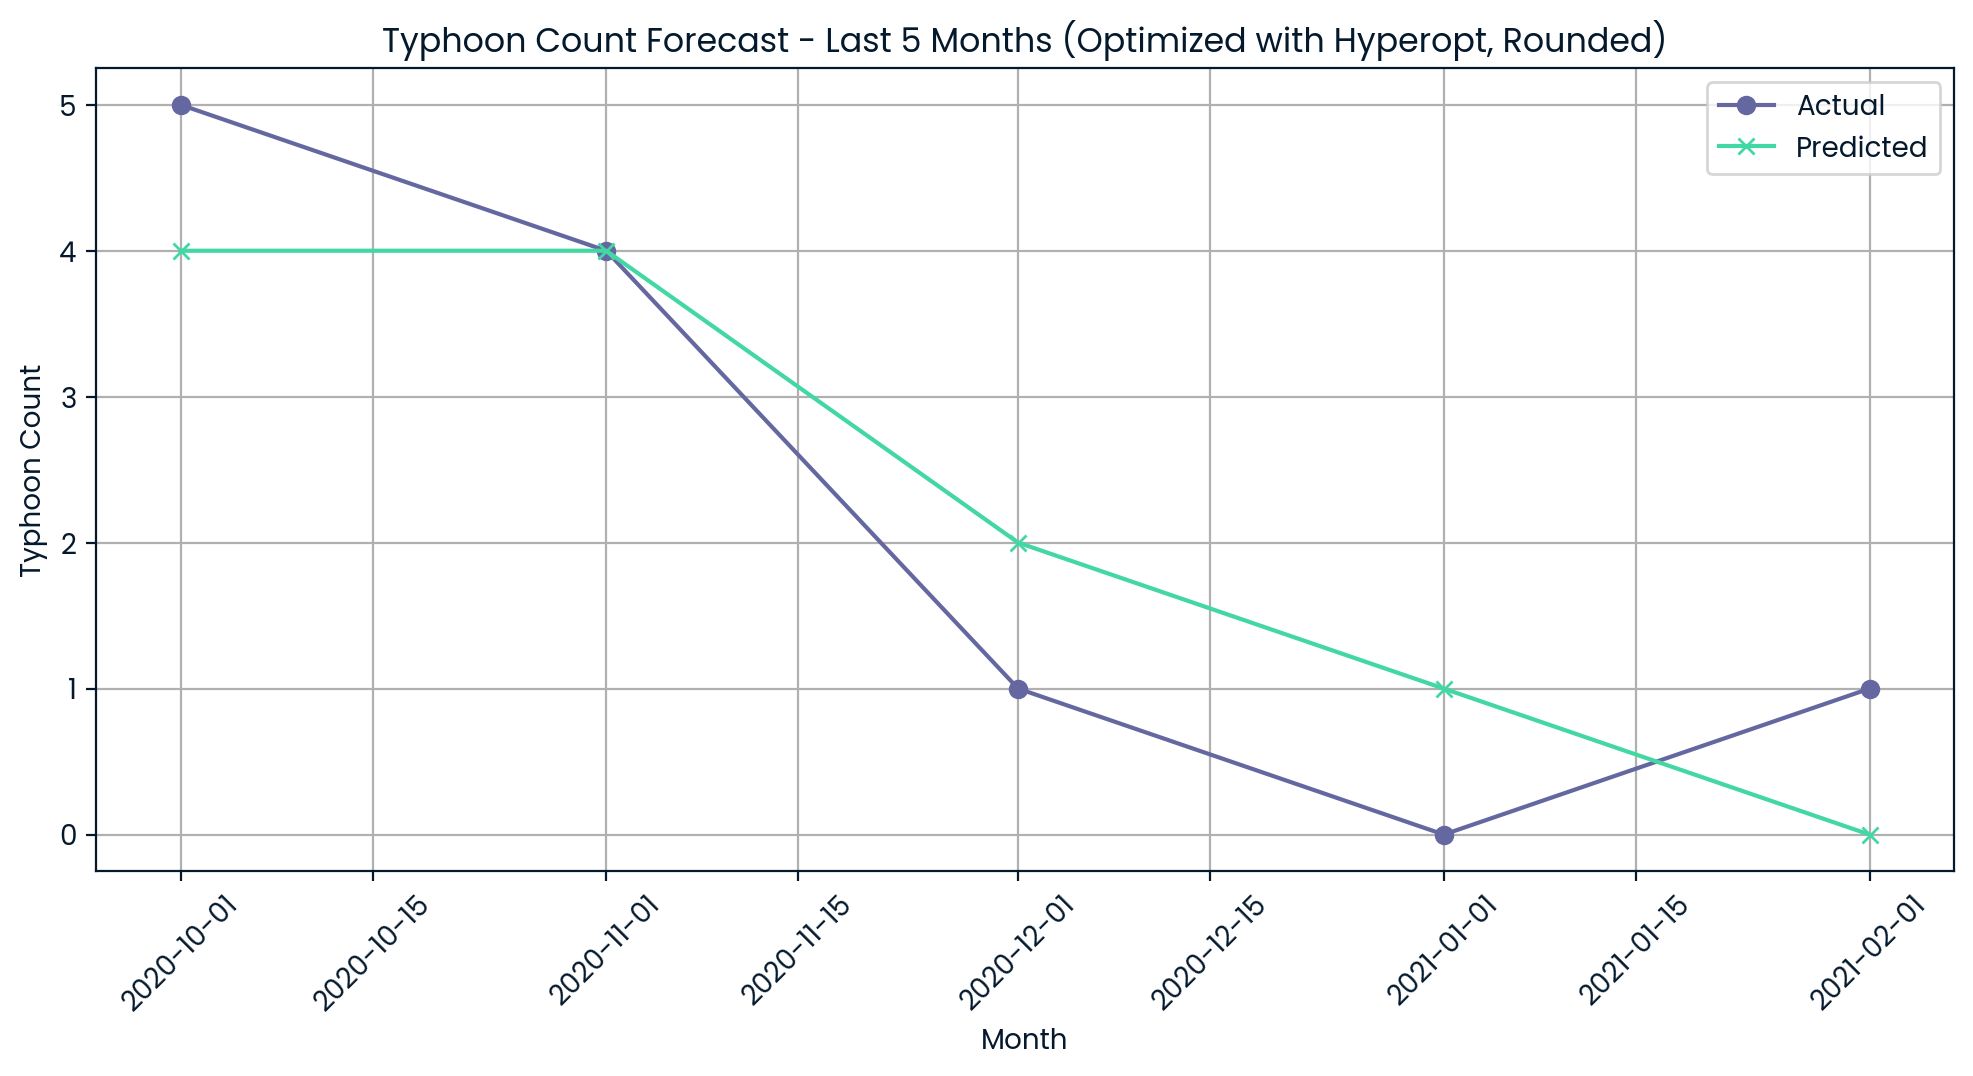

In [5]:
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, Trials
from functools import partial
import os

# the same dataframe df_lagged will be used (see section II)

X = df_lagged[feature_cols]
y = df_lagged[target_col]

# Split data into training and a temporary test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=5, shuffle=False)

def objective(params, X_train, y_train, X_val, y_val):
    """Objective function for Hyperopt."""
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    return rmse

# Define the hyperparameter search space for Hyperopt
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),  # Discrete integer
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),  # Continuous log-uniform
    'max_depth': hp.quniform('max_depth', 2, 10, 1),  # Discrete integer
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Continuous uniform
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)  # Continuous uniform
}

# Split the temporary training data into training and validation sets for Hyperopt
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, shuffle=False)

# Use partial to pass fixed arguments to the objective function
objective_partial = partial(objective, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

# Run Hyperopt optimization
trials = Trials()
best = fmin(fn=objective_partial,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  # Number of hyperparameter combinations to try
            trials=trials,
            rstate=np.random.default_rng(42) # for reproducibility
           )

print("\nBest hyperparameters found by Hyperopt:")
print(best)

# Train the final XGBoost model with the best hyperparameters on the full training data
best_model = XGBRegressor(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    random_state=42
)
best_model.fit(X_train_temp, y_train_temp)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Round the predictions to the nearest whole number
y_pred_rounded = np.round(y_pred)

# Evaluate the best model using the rounded predictions
mae_rounded = mean_absolute_error(y_test, y_pred_rounded)
rmse_rounded = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
r2_rounded = r2_score(y_test, y_pred_rounded)

# Print metrics for the best model with rounded predictions
print(f"\nPerformance of the best model on the test set (rounded predictions):")
print(f"MAE:  {mae_rounded:.2f}")
print(f"RMSE: {rmse_rounded:.2f}")
print(f"R²:   {r2_rounded:.2f}")

# Prediction DataFrame for the best model with rounded predictions
pred_df_rounded = pd.DataFrame({
    'DATE': df_lagged.iloc[-5:]['DATE'].values,
    'Actual': y_test.values,
    'Predicted': y_pred_rounded
})
print("\nPredictions for the last 5 months (best model - Hyperopt, rounded):")
print(pred_df_rounded)

# Plot predictions vs. actual values for the best model with rounded predictions
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(pred_df_rounded['DATE'], pred_df_rounded['Actual'], label='Actual', marker='o')
plt.plot(pred_df_rounded['DATE'], pred_df_rounded['Predicted'], label='Predicted', marker='x')
plt.title("Typhoon Count Forecast - Last 5 Months (Optimized with Hyperopt, Rounded)")
plt.xlabel("Month")
plt.ylabel("Typhoon Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Results reveal that the MAE was reduced (compared to that without performing Bayesian optimization) from 0.9 to 0.8. While results seem favoriable, note that the holdout method is a cross-validation strategy that provide a limited and potentially unreliable estimate of model performance because it relies on a single train-test split.

# IV. TimeSeriesSplit with `hyperopt`-based Bayesian Optimization

Given the need for a robust performance estimation, I transitioned to using TimeSeriesSplit, which respects temporal order while offering multiple validation sets. Rather than calculating the maximum allowable number of splits by formula, I arbitrarily set the number of train-validation splits (n_splits) to 5 based on initial inspection of the data.

This adjustment assesses model performance across five distinct historical periods instead of relying on a single holdout set. For final evaluation, we reserved the last 5 data points as the out-of-sample test set, ensuring that our main prediction target was not touched during model training or tuning.

We continued to use an XGBoost model, fitted on the training portion of each split. I still applied Bayesian optimization using the `hyperopt` library to  search for hyperparameters that minimize prediction error. The final XGBoost model, trained with the best hyperparameters identified, was evaluated using MAE, RMSE, and $R^{2}$.

100%|██████████| 50/50 [00:14<00:00,  3.43trial/s, best loss: 1.017947767823333] 

Performance on this fold (rounded predictions):
MAE:  0.80
RMSE: 1.41
R²:    0.00
100%|██████████| 50/50 [00:14<00:00,  3.52trial/s, best loss: 1.0430929676615075]

Performance on this fold (rounded predictions):
MAE:  1.20
RMSE: 1.26
R²:    -0.11
100%|██████████| 50/50 [00:15<00:00,  3.31trial/s, best loss: 1.0675925628585703]

Performance on this fold (rounded predictions):
MAE:  0.40
RMSE: 0.63
R²:    0.38
100%|██████████| 50/50 [00:17<00:00,  2.87trial/s, best loss: 1.0456176358419285]

Performance on this fold (rounded predictions):
MAE:  1.40
RMSE: 1.73
R²:    0.34
100%|██████████| 50/50 [00:13<00:00,  3.77trial/s, best loss: 1.1136225800589352]

Performance on this fold (rounded predictions):
MAE:  0.80
RMSE: 0.89
R²:    0.79

Average Performance across 5 folds:
Average MAE:  0.92
Average RMSE: 1.19
Average R²:    0.28

Final Predictions (Last 5 periods):
         DATE  Actual  Predicted
20 2019-1

<Figure size 640x480 with 0 Axes>

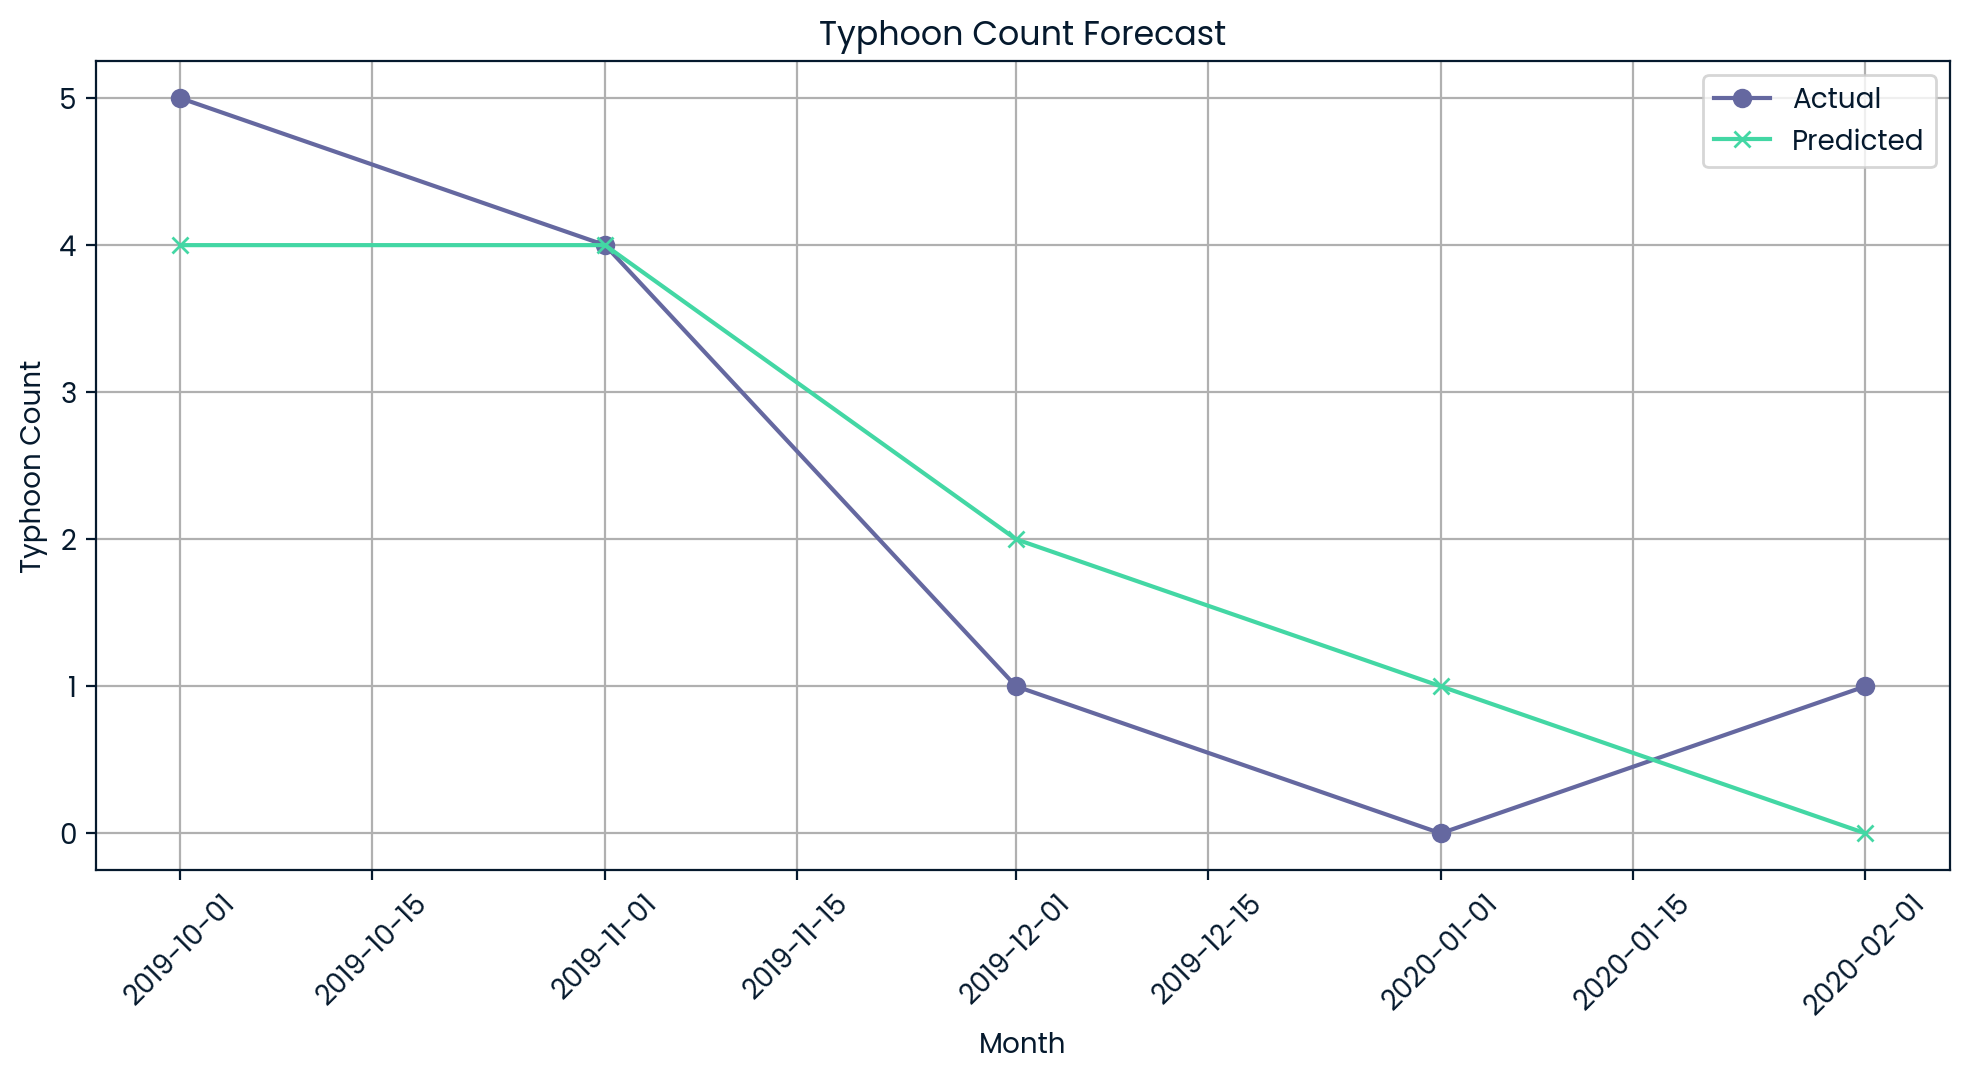

In [8]:
from sklearn.model_selection import TimeSeriesSplit

# the same dataframe df_lagged will be used

X = df_lagged[feature_cols].values  # convert X to a numpy array
y = df_lagged[target_col].values  # convert y to a numpy array

# TimeSeriesSplit Setup
# Initialize TimeSeriesSplit
n_splits = 5  # Example: Adjust as needed
test_size = 5  # Example: Adjust as needed
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)


# Hyperparameter Optimization within TimeSeriesSplit Loop
def objective(params, X_train, y_train, X_val, y_val):
    """Objective function for Hyperopt."""
    # Convert to NumPy arrays (ensuring they are arrays)
    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train)
    X_val_np = np.array(X_val)
    y_val_np = np.array(y_val)

    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
    )
    model.fit(X_train_np, y_train_np)
    y_pred_val = model.predict(X_val_np)
    rmse = np.sqrt(mean_squared_error(y_val_np, y_pred_val))
    return rmse



# Define the hyperparameter search space for Hyperopt
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

all_mae_scores = []
all_rmse_scores = []
all_r2_scores = []
final_predictions = pd.DataFrame({'DATE': [], 
                                  'Actual': [], 
                                  'Predicted': []})  # initialize


# Loop through the TimeSeriesSplit folds
for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Split the training fold into training and validation sets for Hyperopt
    X_train_hyperopt, X_val_hyperopt, y_train_hyperopt, y_val_hyperopt = train_test_split(
        X_train_fold, y_train_fold, test_size=0.2, shuffle=False
    )

    # Use partial to pass fixed arguments to the objective function
    objective_partial = partial(
        objective,
        X_train=X_train_hyperopt,
        y_train=y_train_hyperopt,
        X_val=X_val_hyperopt,
        y_val=y_val_hyperopt,
    )

    # Run Hyperopt optimization
    trials = Trials()
    try:
        best = fmin(
            fn=objective_partial,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42),
        )
    except Exception as e:
        print(f"Error during Hyperopt optimization: {e}")
        # Handle the error, e.g., by skipping to the next fold or breaking the loop.
        exit()

    # Train the final XGBoost model with the best hyperparameters on the fold's full training data
    best_model = XGBRegressor(
        n_estimators=int(best['n_estimators']),
        learning_rate=best['learning_rate'],
        max_depth=int(best['max_depth']),
        subsample=best['subsample'],
        colsample_bytree=best['colsample_bytree'],
        random_state=42,
    )
    best_model.fit(X_train_fold, y_train_fold)

    # Predict on the test set
    y_pred_fold = best_model.predict(X_test_fold)
    y_pred_rounded_fold = np.round(y_pred_fold)

    # Evaluate the model
    mae_fold = mean_absolute_error(y_test_fold, y_pred_rounded_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_rounded_fold))
    r2_fold = r2_score(y_test_fold, y_pred_rounded_fold)

    all_mae_scores.append(mae_fold)
    all_rmse_scores.append(rmse_fold)
    all_r2_scores.append(r2_fold)

    # Store the predictions of the *current* fold, including the DATE
    fold_predictions = pd.DataFrame({
        'DATE': df.iloc[test_index]['DATE'].values,
        'Actual': y_test_fold,
        'Predicted': y_pred_rounded_fold,
    })
    final_predictions = pd.concat([final_predictions, fold_predictions], ignore_index=True) #changed concat

    print(f"\nPerformance on this fold (rounded predictions):")
    print(f"MAE:  {mae_fold:.2f}")
    print(f"RMSE: {rmse_fold:.2f}")
    print(f"R²:    {r2_fold:.2f}")



# Overall Evaluation and Results
# Print the metrics for the last fold
print(f"\nAverage Performance across {n_splits} folds:")
print(f"Average MAE:  {np.mean(all_mae_scores):.2f}")
print(f"Average RMSE: {np.mean(all_rmse_scores):.2f}")
print(f"Average R²:    {np.mean(all_r2_scores):.2f}")

# Print the final predictions
print("\nFinal Predictions (Last 5 periods):")
print(final_predictions.tail(5)) # changed to last 5

# Plotting
# Plot predictions vs. actual values
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(final_predictions.tail(5)['DATE'], final_predictions.tail(5)['Actual'], label='Actual', marker='o')
plt.plot(final_predictions.tail(5)['DATE'], final_predictions.tail(5)['Predicted'], label='Predicted', marker='x')
plt.title("Typhoon Count Forecast") # general title
plt.xlabel("Month")
plt.ylabel("Typhoon Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In TimeSeriesSplit, each cross-validation fold involves training a new model on the training data available up to that point. However, for the final model used in deployment or to evaluate performance on the held-out test set, we retrain it using all available training data. This ensures the deployed model benefits from the most comprehensive historical data, providing the strongest possible basis for predicting unseen values. This final retraining step is standard practice, as it avoids discarding valuable information and optimizes predictive accuracy.

Results reveal that the model yielded a MAE of 0.8. Both holdout and TimeSeriesSplit methods show the model has an MAE of 0.8, indicating consistent predictive performance.

The project is in early stages, with plans to explore other machine learning methods and increase the prediction window to 12 months.

If you have questions, send them my way at jprmaulion[at]gmail[dot]com.